## Interface with `py_sc_fermi`

To extend the analysis available in doped, we include an optional interface with the [`py_sc_fermi`](https://github.com/bjmorgan/py-sc-fermi) code for analysis of self-consistent Fermi energies and defect concentrations. We'll go through how to use the interface to study defect concentrations in the CdTe.

The majority of the functionality of this interface is contained within the `FermiSolver` class, for which there are two subclasses, the `FermiSolverPyScFermi` and `FermiSolverDoped`. Each provides similar functionaility, but the `FermiSolverPyScFermi` class extends what is possible with doped, with some different analysis functionality which we will describe in this notebook.

### CdTe

We'll start by using the familiar CdTe example to outline the basic functionality of the FermiSolvers. The first step is simply to generate the `FermiSolver` objects

In [1]:
from doped.interface.fermi_solver import FermiSolverDoped, FermiSolverPyScFermi
from monty.serialization import loadfn
import matplotlib.pyplot as plt
import pandas as pd

# we can use the doped style file to make all our plots look consistent
style_file = "../doped/utils/doped.mplstyle"
plt.style.use(style_file)

# we need to specify the path to the vasprun.xml file
# that was used for the DOS calculation. This is because
# we need to accurately account for the electronic carrier concentrations
# as well as the defect concentrations to determine the Fermi level
vasprun_path = "CdTe/CdTe_prim_k181818_NKRED_2_vasprun.xml.gz"

# the DefectThermodynamics object contains all the information about the
# defect formation energies and transition levels. It will underpin both the
# doped and py-sc-fermi solvers
thermodynamics = loadfn("CdTe/CdTe_LZ_thermo_wout_meta.json")

# and the chemical potentials can then be used to specify the
# defect formation energies under different conditions, and act as a parameter
# space we can scan over to interrogate the defect concentrations
chemical_potentials = loadfn("CdTe/CdTe_chempots.json")

# initialize the FermiSolver objects. The multiplicity_scaling parameter is
# is used to account for the fact that the DOS is calculated for the primitive
# cell, but the multiplicities are calculated for the supercell. The Doped solver
# will take care of this internally, but the PyScFermi solver requires the user
# to specify this scaling factor
fs = FermiSolverDoped(defect_thermodynamics=thermodynamics, 
                      bulk_dos_vr=vasprun_path)
py_fs = FermiSolverPyScFermi(defect_thermodynamics=thermodynamics, 
                             bulk_dos_vr=vasprun_path,
                             multiplicity_scaling=32)

Once we have the `FermiSolvers`, perhaps the simplest parameter to scan over is the temperature, and we can do so as follows, we will use this as an example to show that the two solvers get equivalent results

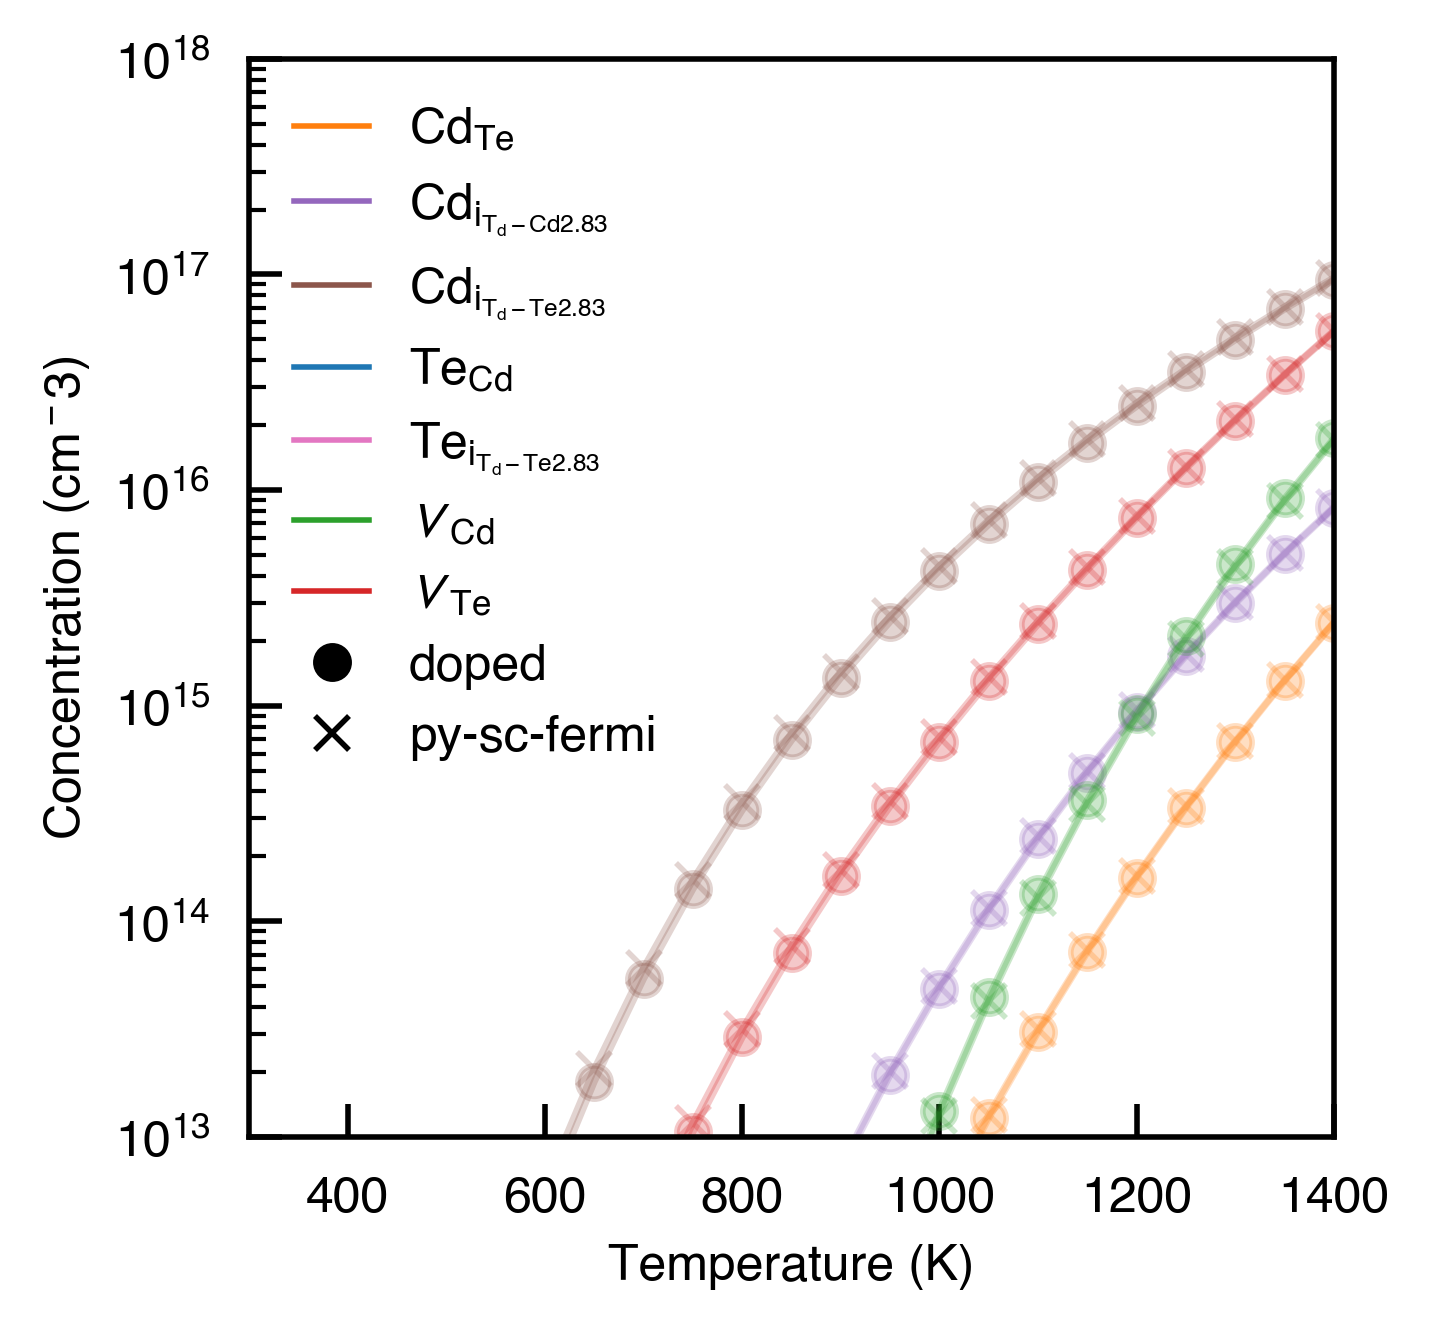

In [2]:
# define a range of temperatures to scan over
import numpy as np
from doped.utils.plotting import _format_defect_name

temperatures = range(300, 1410, 50)  # temperatures to consider, in K

defect_colors = {"Te_Cd": "C0", "Cd_Te": "C1", "v_Cd": "C2", "v_Te": "C3", 
                 "Cd_i_Td_Cd2.83": "C4", "Cd_i_Td_Te2.83": "C5", "Te_i_Td_Te2.83": "C6"}

# the scan_temperature method can be used to scan over a range of temperatures
# and generate a DataFrame containing the defect concentrations, carrier concentrations,
# and Fermi levels at each temperature
temperature_df = fs.scan_temperature(chemical_potentials["facets_wrt_el_refs"]["Cd-CdTe"],
                                    temperatures)
temperature_df_py = py_fs.scan_temperature(chemical_potentials["facets"]["Cd-CdTe"],
                                        temperatures)

temperature_df["backend"] = "doped"
temperature_df_py["backend"] = "py-sc-fermi"

plot_data = pd.concat([temperature_df, temperature_df_py])

# Create a unique list of defects in the DataFrame
unique_defects = temperature_df.index.unique()

fig, ax = plt.subplots()

# loop over the unique defects and plot the defect concentrations
# as a function of temperature, for both the doped and py-sc-fermi backends
for defect in unique_defects:
    defect_df = plot_data.loc[defect]
    
    for backend in ["doped", "py-sc-fermi"]:
        defect_df_backend = defect_df[defect_df["backend"] == backend]
        ax.plot(defect_df_backend["Temperature"], 
                defect_df_backend["Concentration (cm^-3)"], 
                label=_format_defect_name(defect, include_site_info_in_name=True, wout_charge=True), 
                color=defect_colors[defect], 
                marker="o" if backend == "doped" else "x",
                alpha = 0.25)

ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Concentration (cm${^-3}$)")

ax.set_xlim(300, 1400)
ax.set_ylim(1e13, 1e18)
ax.set_yscale("log")

custom_lines = [plt.Line2D([0], [0], color=defect_colors[defect], lw=1) for defect in unique_defects]
custom_lines.append(plt.Line2D([0], [0], color="black", lw=1, marker="o", linestyle="None", label="doped"))
custom_lines.append(plt.Line2D([0], [0], color="black", lw=1, marker="x", linestyle="None", label="py-sc-fermi"))
ax.legend(custom_lines, 
          [f"{_format_defect_name(defect, include_site_info_in_name=True, wout_charge=True)}" for defect in unique_defects] + ["doped", "py-sc-fermi"],
          frameon=False)

plt.show()

To continue to show the functionality of the FermiSolver, we'll show how we can generate a Brouwer-digaram--like figure, with defect concentrations shown as a function of chemical potentials.

Some additional notes of the FermiSolver objects here:

- all of the parameter-scanning functionaility accepts a `processes` argument, which allows the user to use multiprocessing to calculate the number of cores to parallelise the scan over.
- each of the arguments also accepts a `annealing_temperatures` and `quenching_temperatures` argument. These can be single values or list of values, and will carry out "frozen-defect" calculations between these temperatures as discussed in the defect thermodynamics tutorial.

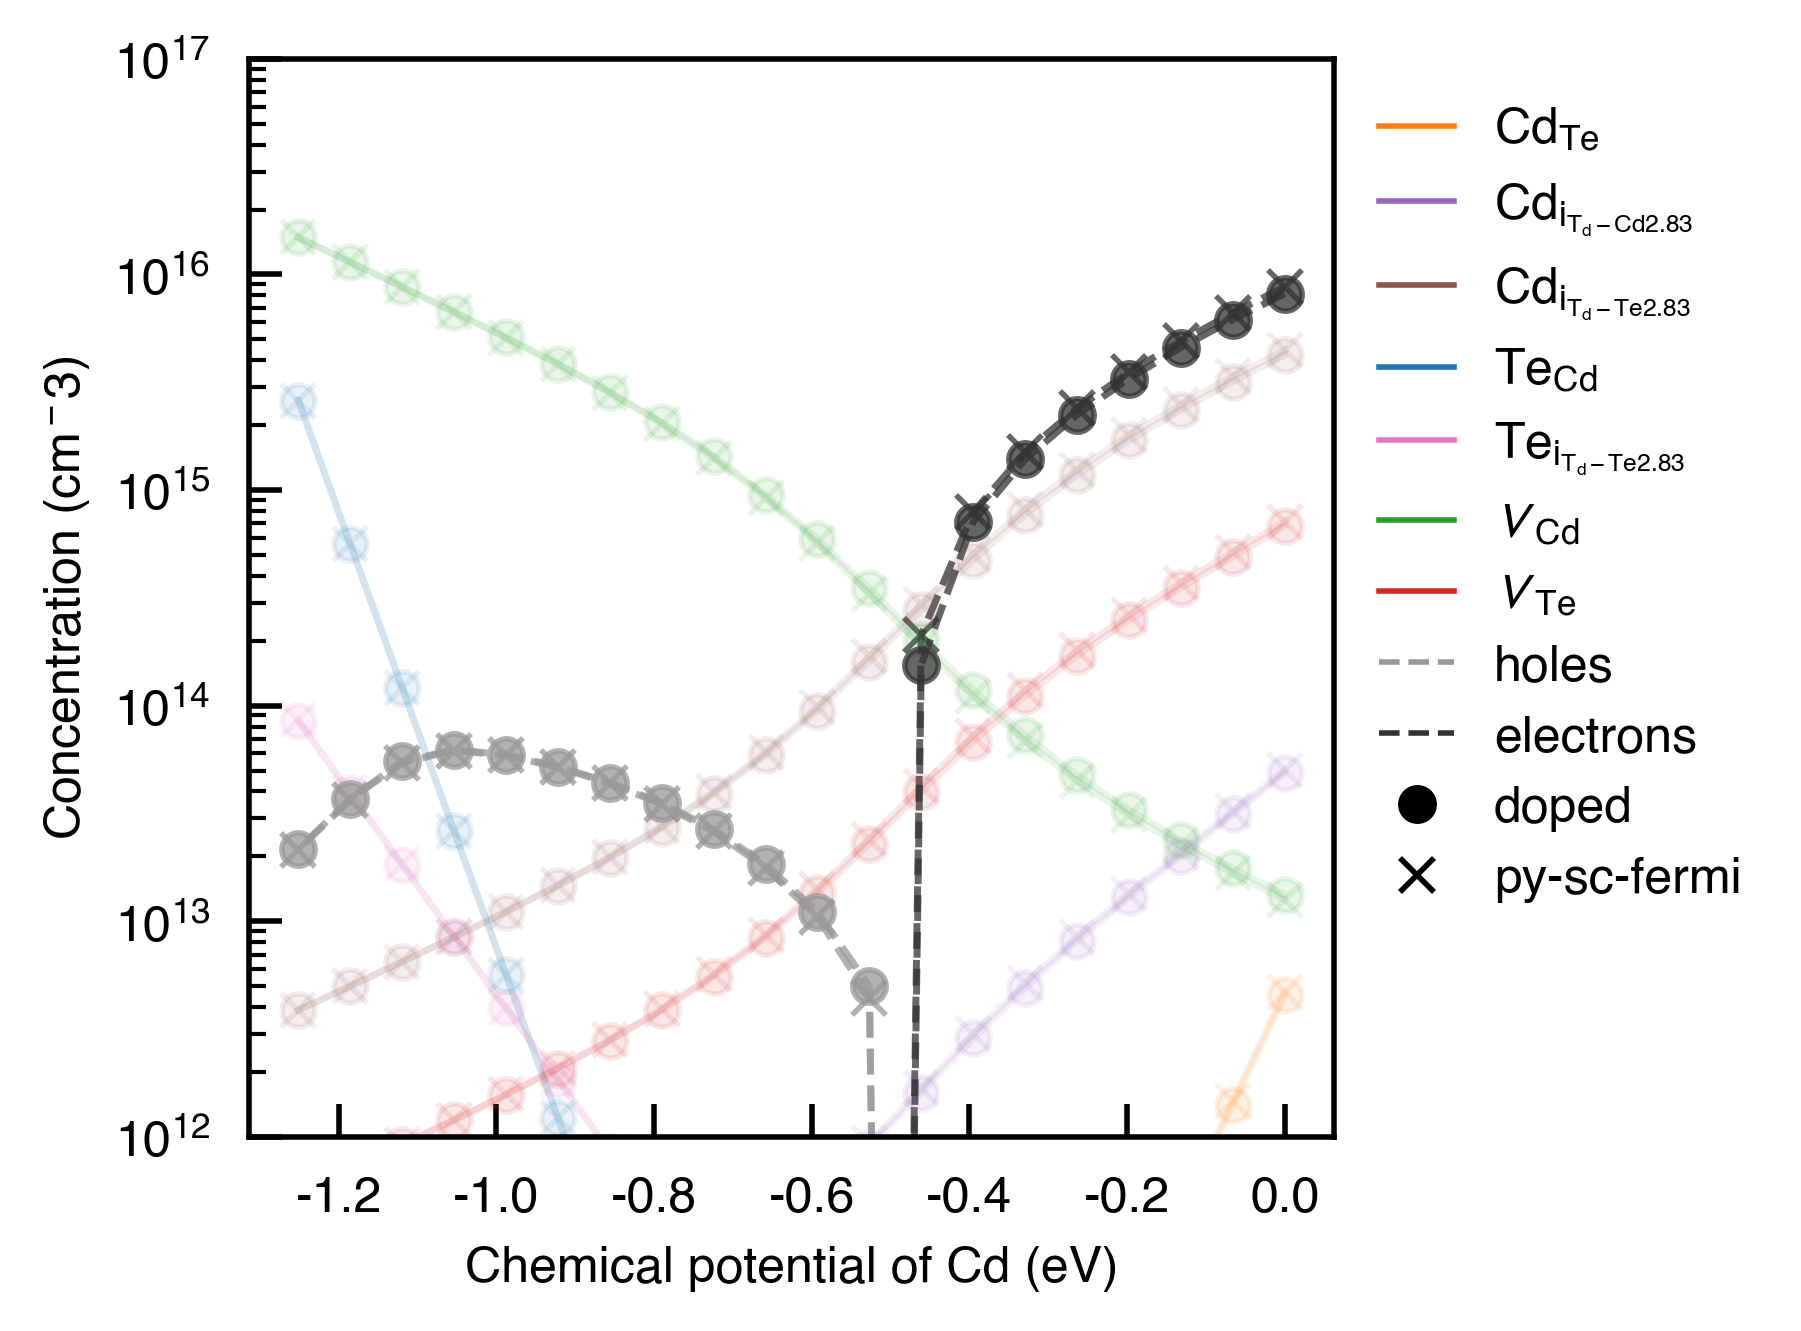

In [3]:

mu_df = py_fs.interpolate_chemical_potentials(chem_pot_start=chemical_potentials["facets"]["Cd-CdTe"], 
                                           chem_pot_end=chemical_potentials["facets"]["CdTe-Te"], 
                                           n_points=20, annealing_temperatures=1000, quenching_temperatures=300,
                                           processes=4)
mu_df_doped = fs.interpolate_chemical_potentials(chem_pot_start=chemical_potentials["facets_wrt_el_refs"]["Cd-CdTe"],
                                                    chem_pot_end=chemical_potentials["facets_wrt_el_refs"]["CdTe-Te"],
                                                    n_points=20, annealing_temperatures=1000, quenching_temperatures=300,
                                                    processes=4)
mu_df["backend"] = "py-sc-fermi"
mu_df_doped["backend"] = "doped"
mu_df = pd.concat([mu_df, mu_df_doped])

fig, ax = plt.subplots()

for backend in ["py-sc-fermi", "doped"]:
    for defect in unique_defects:
        defect_df = mu_df.loc[defect]
        defect_df_backend = defect_df[defect_df["backend"] == backend]
        if backend == "py-sc-fermi":
            defect_df_backend["Cd"] -= chemical_potentials["elemental_refs"]["Cd"]
        ax.plot(defect_df_backend["Cd"], 
            defect_df_backend["Concentration (cm^-3)"], 
            label=_format_defect_name(defect, include_site_info_in_name=True, wout_charge=True), 
            color=defect_colors[defect], 
            marker="o" if backend == "doped" else "x",
            alpha = 0.1)
    ax.plot(defect_df_backend["Cd"], 
            defect_df_backend["Holes (cm^-3)"], 
            marker="o" if backend == "doped" else "x", 
            linestyle="--", 
            alpha = 0.75,
            color = "#999999")
    ax.plot(defect_df_backend["Cd"], 
            defect_df_backend["Electrons (cm^-3)"], 
            marker="o" if backend == "doped" else "x", 
            linestyle="--",
            alpha = 0.75, 
            color = "#333333")

ax.set_xlabel("Chemical potential of Cd (eV)")
ax.set_ylabel("Concentration (cm${^-3}$)")

custom_lines = [plt.Line2D([0], [0], color=defect_colors[defect], lw=1) for defect in unique_defects]
custom_lines.append(plt.Line2D([0], [0], color="#999999", lw=1, linestyle="--", label="holes"))
custom_lines.append(plt.Line2D([0], [0], color="#333333", lw=1, linestyle="--", label="electrons"))
custom_lines.append(plt.Line2D([0], [0], color="black", lw=1, marker="o", linestyle="None", label="doped"))
custom_lines.append(plt.Line2D([0], [0], color="black", lw=1, marker="x", linestyle="None", label="py-sc-fermi"))

plt.legend(custom_lines, 
          [f"{_format_defect_name(defect, include_site_info_in_name=True, wout_charge=True)}" for defect in unique_defects] + ["holes", "electrons", "doped", "py-sc-fermi"],
          frameon=False, loc="upper left", bbox_to_anchor=(1, 1))
plt.ylim(1e12, 1e17)
plt.yscale("log")
plt.show()

To show how we can provide a list of annealing temperatures or quenching temperatures to get defect system properties as a function of two parameters, we show a quick example below. The interpolation in chemical potential space (`n_points`) is fairly low. You would likely want to increase this for your own production code.

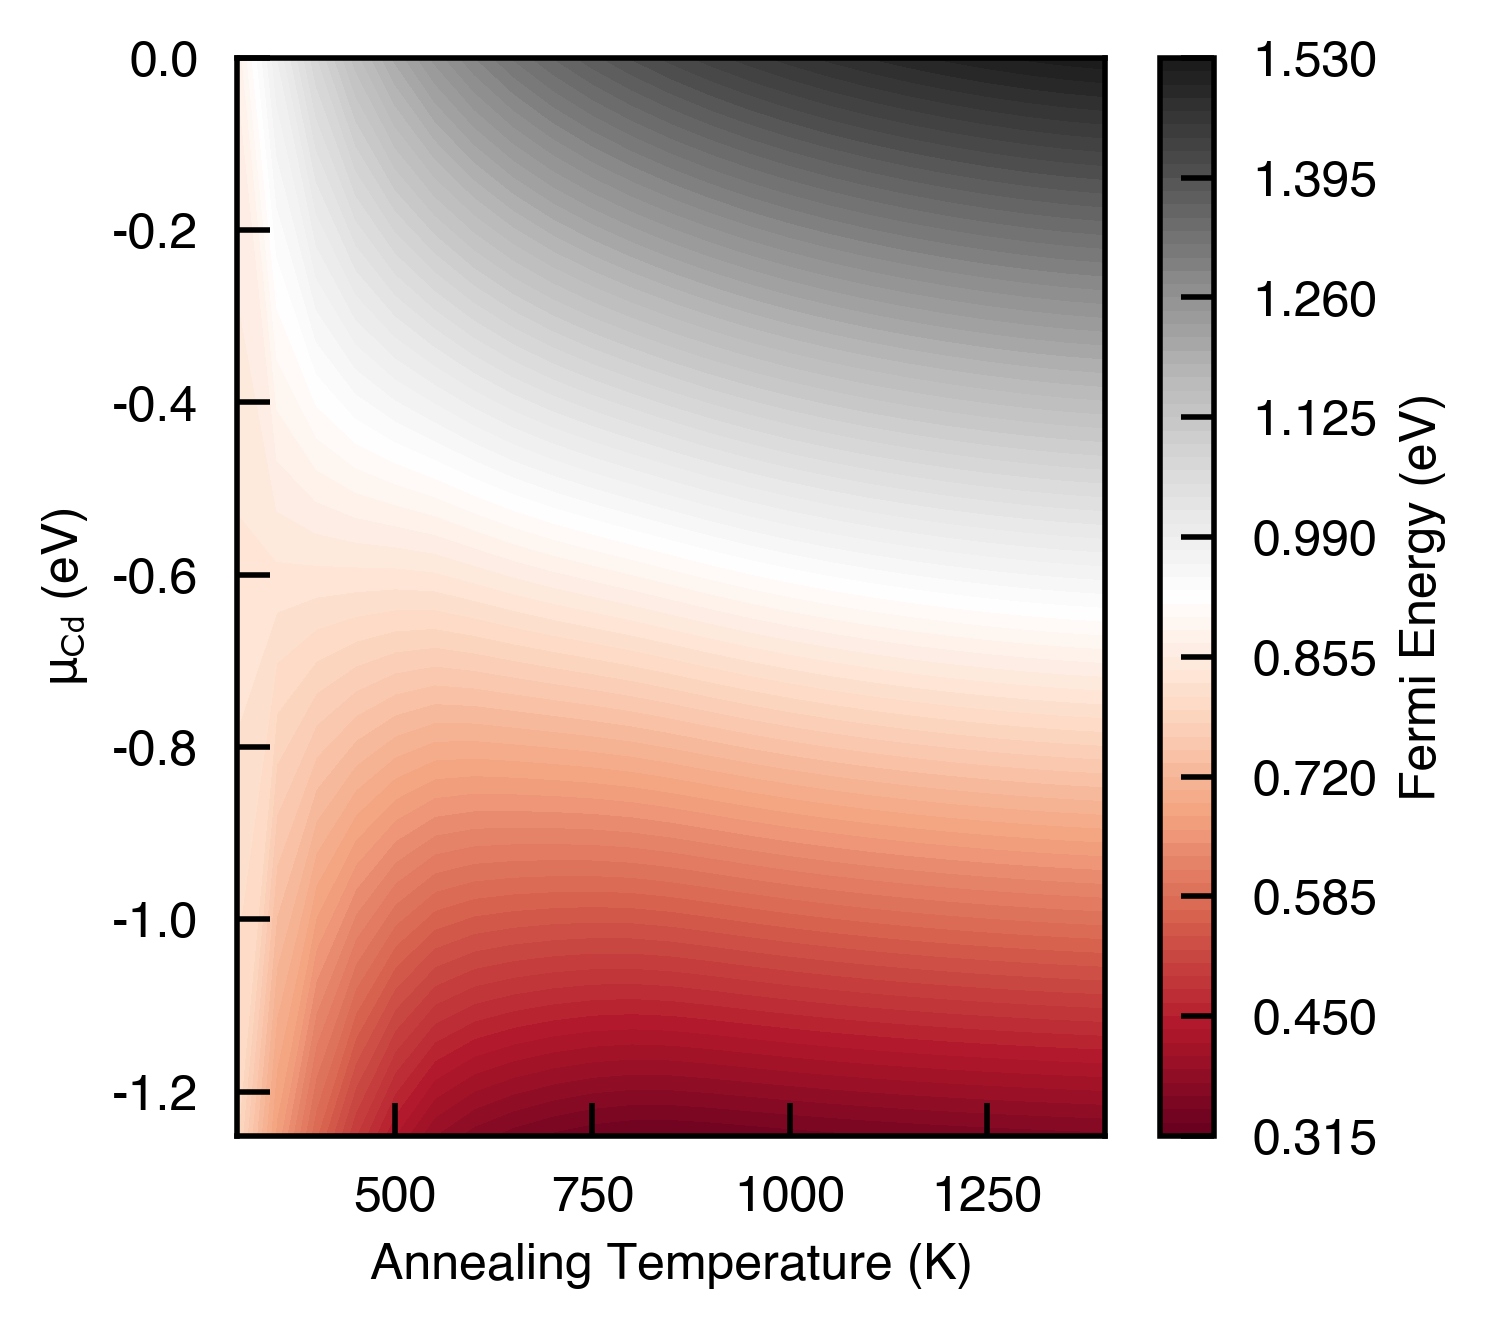

In [4]:

df = fs.interpolate_chemical_potentials(chem_pot_start=chemical_potentials["facets_wrt_el_refs"]["Cd-CdTe"],
                                    chem_pot_end=chemical_potentials["facets_wrt_el_refs"]["CdTe-Te"],
                                    n_points=2, annealing_temperatures=list(temperatures), quenching_temperatures=300,
                                    processes=4)

# Create a pivot table of the Fermi level as a function of the chemical potential and temperature
pivot_df = df.pivot_table(index='Annealing Temperature', columns='Cd', values='Fermi Level', aggfunc='max')

# Create a grid of (mu_Cd) and y (temperature) values
x = np.array(pivot_df.columns)
y = np.array(pivot_df.index)
Y, X = np.meshgrid(x, y)

# Create the contour plot

plt.ylabel(r'$\mu_\mathrm{Cd}$ (eV)')
plt.xlabel("Annealing Temperature (K)")

plt.contourf(X, Y, pivot_df.values, levels=100, cmap='RdGy')
plt.colorbar(label='Fermi Energy (eV)')
plt.show()

So far, we have only really replicated what we can do with doped. What additional things can we do with `py-sc-fermi`?

1. Effective dopant concentrations

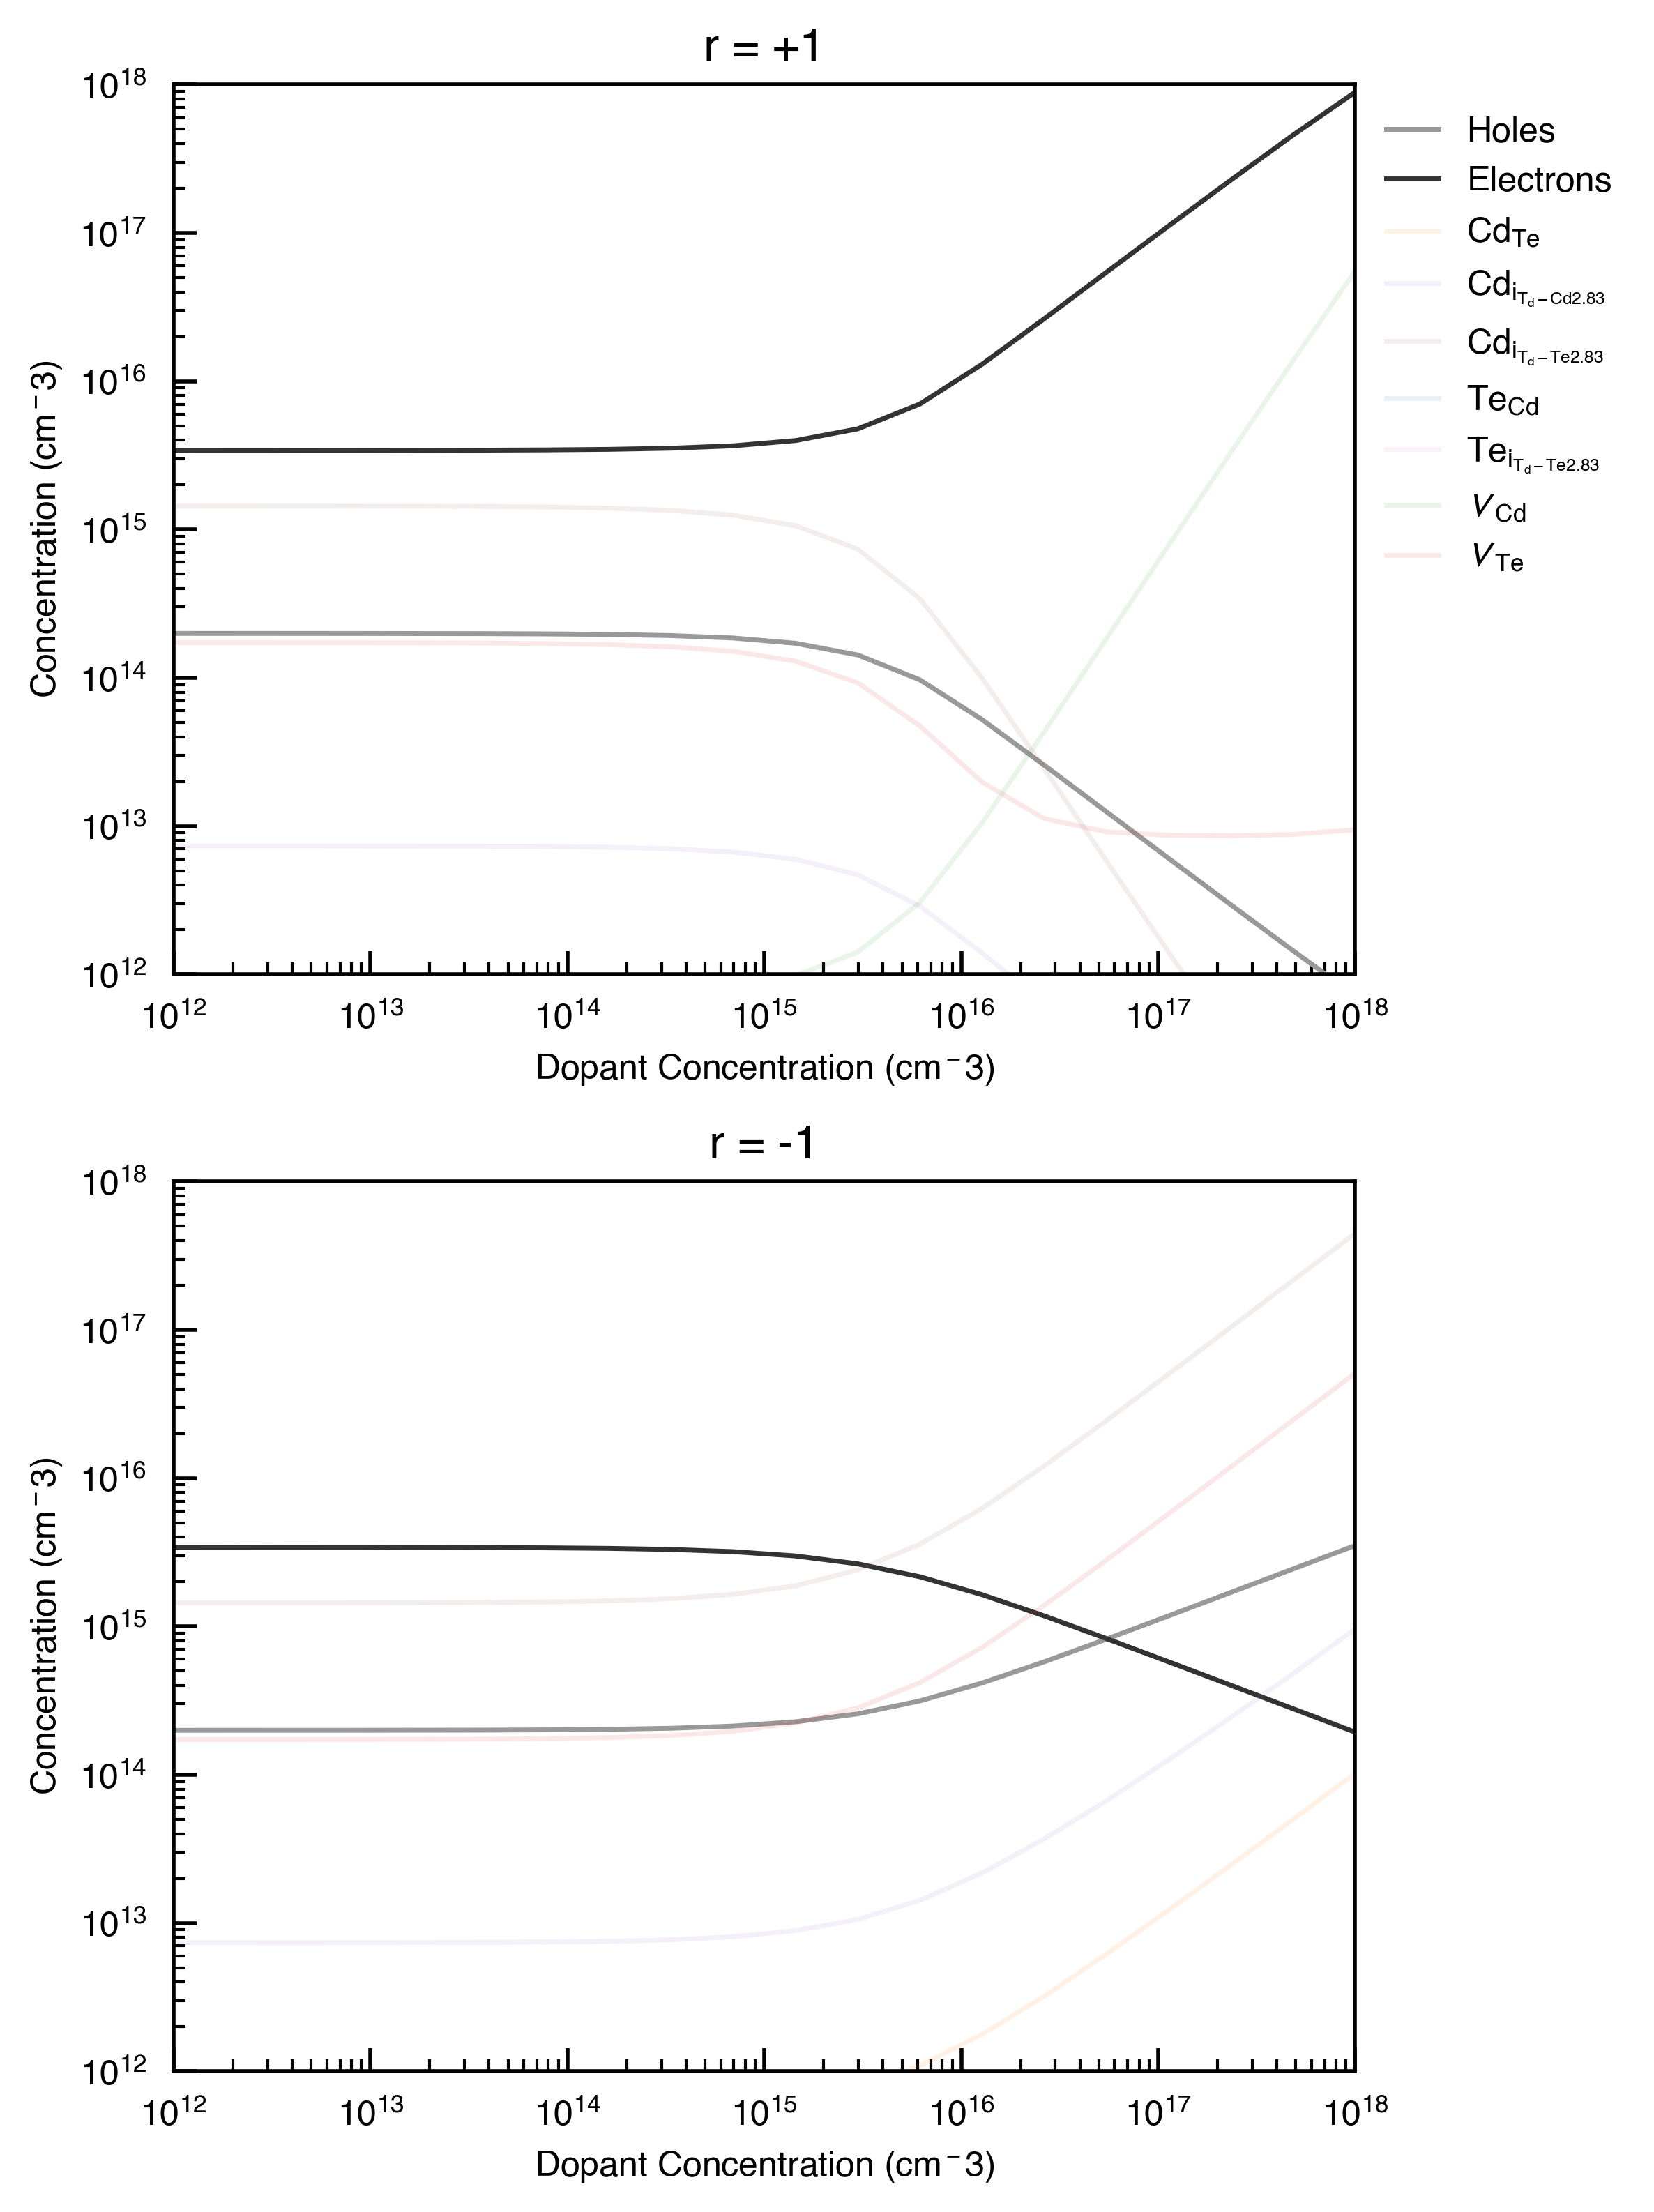

In [18]:
dopant_concentrations = np.logspace(12, 18, 20)


fig, ax = plt.subplots(2, 1, figsize=(6, 8))

dopant_df_positive = py_fs.scan_dopant_concentration(chemical_potentials["facets"]["Cd-CdTe"],
                                                    900, 
                                                    dopant_concentration_range=dopant_concentrations)
dopant_df_negative = py_fs.scan_dopant_concentration(chemical_potentials["facets"]["Cd-CdTe"], 
                                                     900, 
                                                     dopant_concentration_range=-dopant_concentrations)

ax[0].plot(dopant_df_positive["Dopant (cm^-3)"], dopant_df_positive["Holes (cm^-3)"],
                label="Holes",
                color="#999999")
ax[0].plot(dopant_df_positive["Dopant (cm^-3)"], dopant_df_positive["Electrons (cm^-3)"],
                label="Electrons",
                color="#333333")

ax[1].plot(dopant_df_negative["Dopant (cm^-3)"], dopant_df_negative["Holes (cm^-3)"],
                label="Holes",
                color="#999999")
ax[1].plot(dopant_df_negative["Dopant (cm^-3)"], dopant_df_negative["Electrons (cm^-3)"],
                label="Electrons",
                color="#333333")

for defect in unique_defects:
    defect_df = dopant_df_positive.loc[defect]
    ax[0].plot(dopant_concentrations, defect_df["Concentration (cm^-3)"], 
                label=_format_defect_name(defect, include_site_info_in_name=True, wout_charge=True), 
                color=defect_colors[defect], 
                alpha=0.1)
    ax[0].set_title(f"r = +1")
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[0].set_xlabel("Dopant Concentration (cm${^-3}$)")
    ax[0].set_ylabel("Concentration (cm${^-3}$)")
    ax[0].legend(frameon=False, loc="upper left", bbox_to_anchor=(1, 1))

    defect_df = dopant_df_negative.loc[defect]
    ax[1].plot(dopant_concentrations, defect_df["Concentration (cm^-3)"], 
                label=_format_defect_name(defect, include_site_info_in_name=True, wout_charge=True), 
                color=defect_colors[defect], 
                alpha=0.1)
    ax[1].set_title(f"r = -1")
    ax[1].set_xscale("log")
    ax[1].set_yscale("log")
    ax[1].set_xlabel("Dopant Concentration (cm${^-3}$)")
    ax[1].set_ylabel("Concentration (cm${^-3}$)")


ax[1].set_xlabel("Dopant Concentration (cm${^-3}$)")
ax[0].set_ylabel("Concentration (cm${^-3}$)")
ax[1].set_ylabel("Concentration (cm${^-3}$)")

ax[0].set_xlim(1e12, 1e18)
ax[1].set_xlim(1e12, 1e18)
ax[0].set_ylim(1e12, 1e18)
ax[1].set_ylim(1e12, 1e18)

plt.yscale("log")
plt.xscale("log")



plt.tight_layout()
plt.show()
